This tutorial can be downloaded [link](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/basic/basic_002.ipynb).

# 2.0 Analyzing the frequency dependency in GW calculations

We analyze the frequency dependency of the GW self-energy, by exploring two ways of solving the Quasiparticle equation: 

- without linearization 

\begin{align}
E-\varepsilon_{KS} = \langle \Sigma(E) -V_{xc} \rangle
\end{align}

- with linearization (first-order expansion of self-energy in the frequency domain)

\begin{align}
E-\varepsilon_{KS} = \langle \Sigma(\varepsilon_{KS}) -V_{xc} \rangle + (E-\varepsilon_{KS}) \langle \frac{\partial\Sigma}{\partial E}(\varepsilon_{KS}) \rangle
\end{align}

where $\varepsilon_{KS}$ is the Kohn-Sham energy, and $E$ is the QP energy obtained at the $G_0W_0$ level of theory. 

After completing step 1 and step 2 of the [1.0 Tutorial](http://greatfire.uchicago.edu/west-public/West/raw/master/Doc/tutorials/basic_001.ipynb), we download the following file: 

In [1]:
%%bash
wget -N -q http://www.west-code.org/doc/training/silane/wfreq_spec.in

Let's inspect the ``wfreq_spec.in`` file, input for ``wfreq.x``.

In [1]:
%%bash
cat wfreq_spec.in

input_west:
    qe_prefix: silane
    west_prefix: silane
    outdir: ./

wstat_control:
    wstat_calculation: S
    n_pdep_eigen: 50

wfreq_control:
    wfreq_calculation: XWGQP
    n_pdep_eigen_to_use: 50
    qp_bandrange: [4,5]
    n_refreq: 2000
    ecut_refreq: 2.0
    ecut_spectralf: [-1.5,0.5]
    n_spectralf: 2000


Run ``wfreq.x`` on 2 cores.

In [ ]:
%%bash
mpirun -n 2 wfreq.x < wfreq_spec.in > wfreq_spec.out

The output file ``wfreq.out`` contains information about the calculation of the GW self-energy, and the corrected electronic structure can be found in the file ``<west_prefix>.wfreq.save/wfreq.json``.

Below we show how to load and plot the frequency-dependent quasiparticle corrections. 

In [3]:
import json
import numpy as np

# Load the output data 
with open('silane.wfreq.save/wfreq.json') as json_file:
    data = json.load(json_file)

# Extract converged quasiparticle (QP) corrections
k=1 
kindex = f"K{k:06d}"
    
bandmap = data["output"]["Q"]["bandmap"]
eqp = data["output"]["Q"][kindex]

freqlist = np.array(data["output"]["P"]["freqlist"], dtype="f8")
spf = data["output"]["P"][kindex]

    k      |    band    |    eks [eV]     |   eqpLin [eV]   |   eqpSec [eV]  
-----------------------------------------------------------------------------
    1      |     4      |     -8.230      |     -12.150     |     -12.044    


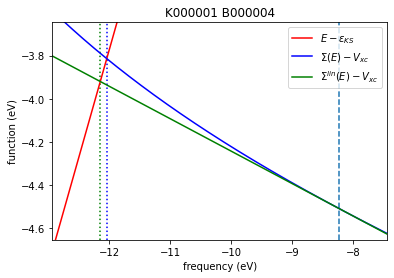

    k      |    band    |    eks [eV]     |   eqpLin [eV]   |   eqpSec [eV]  
-----------------------------------------------------------------------------
    1      |     5      |     -0.466      |      0.666      |      0.665     


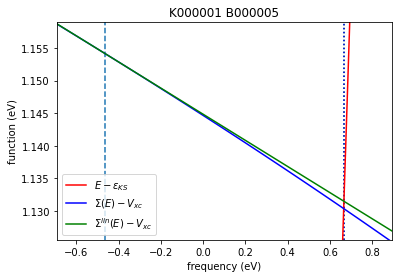

In [10]:
# Plot
import matplotlib.pyplot as plt

for i, b in enumerate(bandmap) : 
    
    eks, eqpLin, eqpSec = eqp['eks'][i], eqp['eqpLin'][i], eqp['eqpSec'][i]
    
    # Print QP corrections
    print (f"{'k':^10} | {'band':^10} | {'eks [eV]':^15} | {'eqpLin [eV]':^15} | {'eqpSec [eV]':^15}")
    print(77*"-")
    print(f"{k:^10} | {b:^10} | {eks:^15.3f} | {eqpLin:^15.3f} | {eqpSec:^15.3f}")
    
    sigmax, vxcl, vxcnl = eqp['sigmax'][i], eqp['vxcl'][i], eqp['vxcnl'][i]
    sigmac_eks = eqp['sigmac_eks']['re'][i]
    sigmac_eqpLin = eqp['sigmac_eqpLin']['re'][i]
    sigmac_eqpSec = eqp['sigmac_eqpSec']['re'][i]
    z = eqp['z'][i]
    
    bindex = f"B{b:06d}"
    sigmac = np.array(spf[bindex]['sigmac']['re'], dtype="f8")

    # Left-hand side of QP equation
    plt.plot(freqlist,freqlist-eks,'r-',label=r"$E-\varepsilon_{KS}$")
    
    # Right-hand side of QP equation without linearization
    plt.plot(freqlist,sigmac+sigmax-vxcl-vxcnl,'b-',label=r"$\Sigma(E)-V_{xc}$")

    # Right-hand side of QP equation with linearization 
    plt.plot(freqlist,sigmac_eks+sigmax-vxcl-vxcnl+(1-1/z)*(freqlist-eks),'g-',label=r"$\Sigma^{lin}(E)-V_{xc}$")

    plt.legend()
    plt.title(kindex+" "+bindex)
    plt.xlabel("frequency (eV)")
    plt.ylabel("function (eV)")
    xmin, xmax = min(eks, eqpLin, eqpSec), max(eks, eqpLin, eqpSec)
    ymin, ymax = min(sigmac_eks, sigmac_eqpLin, sigmac_eqpSec), max(sigmac_eks, sigmac_eqpLin, sigmac_eqpSec)
    ymin += sigmax - vxcl -vxcnl 
    ymax += sigmax - vxcl -vxcnl
    plt.vlines(x=eks,ymin=ymin-0.2*(ymax-ymin),ymax=ymax+0.2*(ymax-ymin),ls="--")
    plt.vlines(x=eqpLin,ymin=ymin-0.2*(ymax-ymin),ymax=ymax+0.2*(ymax-ymin),ls=":",color="g")
    plt.vlines(x=eqpSec,ymin=ymin-0.2*(ymax-ymin),ymax=ymax+0.2*(ymax-ymin),ls=":",color="b")
    plt.xlim([xmin-0.2*(xmax-xmin),xmax+0.2*(xmax-xmin)])
    plt.ylim([ymin-0.2*(ymax-ymin),ymax+0.2*(ymax-ymin)])
    plt.show()

We see that `eqpLin` (green dotted line) and `eqpSec` (blue dotted line) correspond to the solution of the Quasiparticle equation with and without linearization of the frequency dependency, respectively.